notebook adapted from : https://www.kaggle.com/ehabibrahim758/intel-image-classification-using-pytorch

Lets create path variables for the datasets

In [1]:
train_path = '../input/intel-image-classification/seg_train' + '/seg_train'
test_path = '../input/intel-image-classification/seg_test' + '/seg_test'
pred_path = '../input/intel-image-classification/seg_pred' + '/seg_pred'

Defining a transformation function.

In [2]:
import torchvision.transforms as transforms

my_transforms = transforms.Compose([
                    transforms.Resize((150,150)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(30),
                    transforms.ToTensor(),
                    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205,0.205)),
                    ])
                    
test_transforms = transforms.Compose([
                    transforms.Resize((150,150)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.425,0.415,0.405), (0.205,0.205,0.205)),
                    ])

Use Image dataloader to get the datasets.

In [3]:
import torchvision.datasets as datasets

train_dataset = datasets.ImageFolder(train_path, transform=my_transforms)
test_dataset = datasets.ImageFolder(test_path, transform=test_transforms)

lets sample some of the dataset

In [4]:
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

valid_size= 0.2
num_workers=0
batch_size=64

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(num_train * valid_size)

train_idx, valid_idx= indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_dataloader = DataLoader(train_dataset,num_workers=num_workers, sampler=train_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=False, num_workers=num_workers, batch_size=batch_size)
valid_dataloader = DataLoader(train_dataset, num_workers=num_workers,sampler=valid_sampler, batch_size=batch_size)

tensor(1)


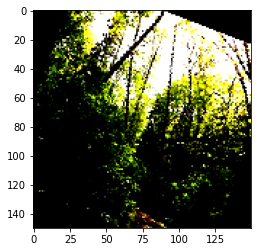

In [5]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_dataloader))
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

imshow(images[1])  

print(labels[1])

In [6]:
print(labels.unique())

tensor([0, 1, 2, 3, 4, 5])


tensor(0)


torch.Size([3, 150, 150])

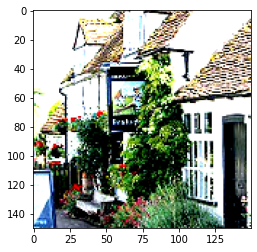

In [7]:
images, labels  = next(iter(test_dataloader))
print(labels[63])
imshow(images[63])

images[63].shape

In [8]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
from torchvision import models

net = models.wide_resnet50_2(pretrained=True)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

In [10]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [11]:
X = torch.randn(1,3,150,150)

net(X).shape

torch.Size([1, 1000])

In [12]:
from torch import nn
for param in net.parameters():
    param.requires_grad = False

in_features = net.fc.in_features
last_layer = nn.Linear(in_features, 6)
net.fc = last_layer
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [13]:
net(X.to(device)).shape

torch.Size([1, 6])

In [14]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.007)
criterion = nn.CrossEntropyLoss()

In [18]:
%%time
epochs =10

valid_loss_min = np.inf

train_arr =  []
valid_arr = []
for e in range(epochs):
    
    train_loss = 0.00
    valid_loss = 0.00
    
    net.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        
        train_loss += loss.item() * images.size(0)
        
    net.eval()
    for images, labels in valid_dataloader :
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        loss = criterion(output, labels)
        valid_loss += loss.item() * images.size(0)
    
    train_loss = train_loss /len(train_dataloader.dataset)
    valid_loss = valid_loss / len(valid_dataloader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1, train_loss, valid_loss))

    if valid_loss <= valid_loss_min :
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), 'net.pt')
        valid_loss_min = valid_loss
    train_arr.append(train_loss)
    valid_arr.append(valid_loss)
    
        

Epoch: 1 	Training Loss: 1.444157 	Validation Loss: 0.361615
Validation loss decreased (inf --> 0.361615).  Saving model ...
Epoch: 2 	Training Loss: 1.447229 	Validation Loss: 0.361413
Validation loss decreased (0.361615 --> 0.361413).  Saving model ...
Epoch: 3 	Training Loss: 1.446689 	Validation Loss: 0.362013
Epoch: 4 	Training Loss: 1.446181 	Validation Loss: 0.360963
Validation loss decreased (0.361413 --> 0.360963).  Saving model ...
Epoch: 5 	Training Loss: 1.448784 	Validation Loss: 0.360367
Validation loss decreased (0.360963 --> 0.360367).  Saving model ...
Epoch: 6 	Training Loss: 1.448433 	Validation Loss: 0.360538
Epoch: 7 	Training Loss: 1.447265 	Validation Loss: 0.361150
Epoch: 8 	Training Loss: 1.445797 	Validation Loss: 0.361335
Epoch: 9 	Training Loss: 1.446683 	Validation Loss: 0.360164
Validation loss decreased (0.360367 --> 0.360164).  Saving model ...
Epoch: 10 	Training Loss: 1.445778 	Validation Loss: 0.361139
CPU times: user 7min 17s, sys: 12.2 s, total: 7mi

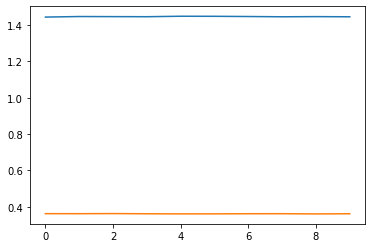

In [20]:
plt.plot(range(epochs), train_arr)
plt.plot(range(epochs), valid_arr)
plt.show()

In [21]:
#load the model 
net.load_state_dict(torch.load('net.pt'))

<All keys matched successfully>

In [22]:
correct_count, all_count = 0,0
for images, labels in test_dataloader:
    for i in range(len(labels)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        img = images[i].view(1,3,150,150)
        with torch.no_grad():
            logps = net(img)
            
        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1
        
print("Number of images Tested=", all_count)
print("\n Model Accuracy=",(correct_count/all_count)*100)

Number of images Tested= 3000

 Model Accuracy= 20.4


thats a very poor accuracy. Will have to try to improve.